In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

from sklearn.metrics import pairwise_distances

In [2]:
data = pd.read_parquet('..ionmob/data/Meier.parquet')
meier_c2 = data[data.charge == 2]

In [3]:
def allowed_ppm(mz, diff=10):
    return mz * 10e-6 * diff

In [36]:
mz_values = sorted(list(set(np.round(data.mz, 3))))


mz_list, ccs_list = [], []
for mz in tqdm(mz_values):
    
    ppm = allowed_ppm(mz)
    
    seqs = meier_c2[(meier_c2.mz >= (mz - ppm)) & (meier_c2.mz <= (mz + ppm))]
    
    if seqs.shape[0] >= 50:
        
        ccs_min = np.min(seqs.ccs.values)
        ccs_max = np.max(seqs.ccs.values)
        ccs_median = np.median(seqs.ccs.values)
        
        distance_reproducable = ccs_median * (1/1000) * 12
        distance_predictor = ccs_median * (1/1000) * 40
        
        all_distances = pairwise_distances(np.expand_dims(seqs.ccs.values, 1)).flatten()
        all_distances = all_distances[all_distances > 0]
        
        good = all_distances[all_distances >= distance_reproducable]
        bad = all_distances[all_distances < distance_reproducable]
        
        good2 = all_distances[all_distances >= distance_predictor]
        bad2 = all_distances[all_distances < distance_predictor]
        
        good_frac = (len(good) / len(all_distances))
        bad_frac = (len(bad) / len(all_distances))
        good2_frac = (len(good2) / len(all_distances))
        bad2_frac = (len(bad2) / len(all_distances))
        
        mz_list.append(mz)
        ccs_list.append(np.array([good_frac, good2_frac]))
        

  0%|          | 0/254484 [00:00<?, ?it/s]

In [37]:
ccs_all = np.array(ccs_list)
mz_list = np.array(mz_list)

In [39]:
ccs_all

array([[0.73632653, 0.2644898 ],
       [0.72816327, 0.24653061],
       [0.72816327, 0.24653061],
       ...,
       [0.72322775, 0.29638009],
       [0.71607843, 0.28784314],
       [0.71607843, 0.28784314]])

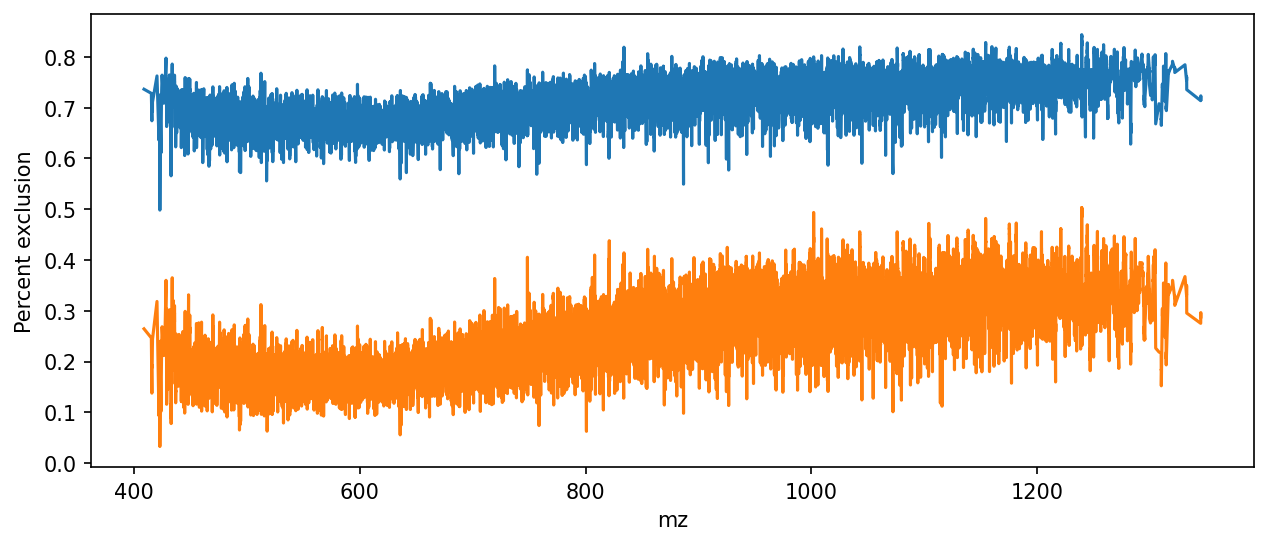

In [43]:
plt.figure(figsize=(10, 4), dpi=150)
plt.plot(mz_list, ccs_all[:, 0], label='reproduction exclusion')
plt.plot(mz_list, ccs_all[:, 1], label='prediction exclusion')
plt.xlabel('mz')
plt.ylabel('Percent exclusion')
plt.show()